In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import scipy.stats as stats
import sys

In [2]:
optimistic_time = 3
most_likely_time = 5
pessimistic_time = 10

In [3]:
alpha = 1 + 4 * (most_likely_time - optimistic_time) / (pessimistic_time - optimistic_time)
beta_param = 1 + 4 * (pessimistic_time - most_likely_time) / (pessimistic_time - optimistic_time)

In [5]:
x = np.linspace(optimistic_time, pessimistic_time, 1000)

In [6]:
y = beta.pdf((x - optimistic_time) / (pessimistic_time - optimistic_time), alpha, beta_param) / (pessimistic_time - optimistic_time)

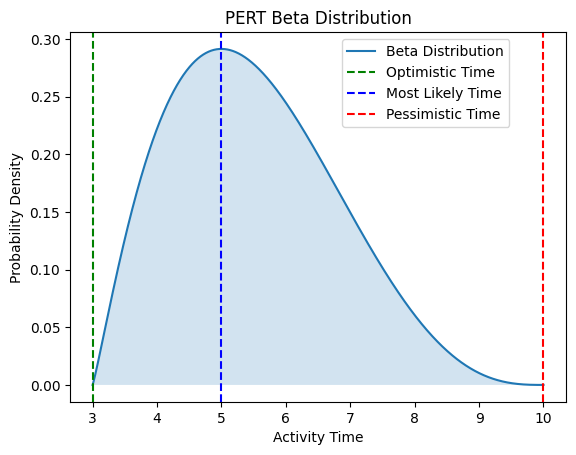

In [11]:
plt.plot(x, y, label='Beta Distribution')
plt.fill_between(x, y, alpha=0.2)

plt.axvline(optimistic_time, color='green', linestyle='--', label='Optimistic Time')
plt.axvline(most_likely_time, color='blue', linestyle='--', label='Most Likely Time')
plt.axvline(pessimistic_time, color='red', linestyle='--', label='Pessimistic Time')

plt.xlabel('Activity Time')
plt.ylabel('Probability Density')
plt.title('PERT Beta Distribution')
plt.legend(loc='upper right', bbox_to_anchor=(0.9, 1))

plt.show()

In [13]:
plan = pd.DataFrame({
    'Activity': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L'],
    'Description': [
        'Define Project Objectives and Scope',
        'Assemble Project Team',
        'Gather Requirements from Stakeholders',
        'Data Collection and Integration',
        'Data Cleaning and Preprocessing',
        'Design Report Templates',
        'Develop Data Processing Pipelines',
        'Implement Report Generation Logic',
        'Develop User Interface for Report Access',
        'Integrate Data Pipelines with Report Generation',
        'Conduct User Testing and Feedback',
        'Finalize and Deploy Automated Reporting Tool'
    ],
    'Dependencies': [None, ['A'], ['A', 'B'], ['C'], ['D'], ['C'], ['E'], ['F'], ['F'], ['G', 'H'], ['I', 'J'], ['K']],
    't': [3, 2, 3, 5, 3, 4, 4, 3, 3, 4, 3, 2]
})

print(plan)

   Activity                                      Description Dependencies  t
0         A              Define Project Objectives and Scope         None  3
1         B                            Assemble Project Team          [A]  2
2         C            Gather Requirements from Stakeholders       [A, B]  3
3         D                  Data Collection and Integration          [C]  5
4         E                  Data Cleaning and Preprocessing          [D]  3
5         F                          Design Report Templates          [C]  4
6         G                Develop Data Processing Pipelines          [E]  4
7         H                Implement Report Generation Logic          [F]  3
8         I         Develop User Interface for Report Access          [F]  3
9         J  Integrate Data Pipelines with Report Generation       [G, H]  4
10        K                Conduct User Testing and Feedback       [I, J]  3
11        L     Finalize and Deploy Automated Reporting Tool          [K]  2

In [16]:
def errorActivityMsg():
    print('Error in input file: Activity')
    sys.exit(1)

def errorDependenciesMsg():
    print('Error in input file: Dependencies')
    sys.exit(1)

def errorMsg():
    print('Error in input file: t')
    sys.exit(1)

In [17]:
def getTaskCode(mydata, code):
    x = 0
    flag = 0
    for i in mydata['Activity']:
        if i == code:
            flag = 1
            break
        x += 1
    if flag == 1:
        return x
    else:
        errorActivityMsg()

In [25]:
def forwardPass(mydata):
    ntask = mydata.shape[0]
    ES = np.zeros(ntask, dtype=np.int32)
    EF = np.zeros(ntask, dtype=np.int32)
    temp=[]

    for i in range(ntask):
        if not mydata['Dependencies'][i]:
            ES[i] = 0
            try:
                EF[i] = ES[i] + mydata['t'][i]
            except:
                errorMsg()
        else:
            for j in mydata['Dependencies'][i]:
                index = getTaskCode(mydata, j)
                if index == i:
                    errorDependenciesMsg()
                else:
                    temp.append(EF[index])
            ES[i] = max(temp)
            try:
                EF[i] = ES[i] + mydata['t'][i]
            except:
                errorMsg()
        
        temp = []
    
    mydata['ES'] = ES
    mydata['EF'] = EF

    return mydata

In [41]:
def backwardPass(mydata):
    ntask = mydata.shape[0]
    temp = []
    LS = np.zeros(ntask, dtype=np.int32)
    LF = np.zeros(ntask, dtype=np.int32)
    Successors = np.empty(ntask, dtype=object)

    for i in range(ntask-1, -1, -1):
        if mydata['Dependencies'][i]:
            for j in mydata['Dependencies'][i]:
                index = getTaskCode(mydata, j)
                if Successors[index] is not None:
                    Successors[index] += mydata['Activity'][i]
                else:
                    Successors[index] = mydata['Activity'][i]

    mydata['Successors'] = Successors

    max_EF = np.max(mydata['EF'])
    for i in range(ntask-1, -1, -1):
        if mydata['Successors'][i] is None:
            LF[i] = max_EF
            LS[i] = LF[i] - mydata['t'][i]
        else:
            for j in mydata['Successors'][i]:
                index = getTaskCode(mydata, j)
                temp.append(LS[index])

            LF[i] = min(temp)
            LS[i] = LF[i] - mydata['t'][i]
            temp = []

    mydata['LS'] = LS
    mydata['LF'] = LF

    return mydata

In [42]:
def slack(mydata):
    ntask = mydata.shape[0]
    Slack = np.zeros(ntask, dtype=np.int32)
    Critical = np.empty(ntask, dtype=object)

    for i in range(ntask):
        Slack[i] = mydata['LS'][i] - mydata['ES'][i]
        if Slack[i] == 0:
            Critical[i] = 'Yes'
        else:
            Critical[i] = 'No'
    
    mydata['Slack'] = Slack
    mydata['Critical'] = Critical

    mydata = mydata.reindex(columns = ['Activity', 'ES', 'EF', 'LS', 'LF', 'Slack', 'Critical'])
    return mydata

In [43]:
def computeCPM(mydata):
    mydata = forwardPass(mydata)
    mydata = backwardPass(mydata)
    mydata = slack(mydata)
    return mydata

In [44]:
def printPlan(mydata):
    pd.set_option('display.max_columns', None)
    print('Automated Reporting Tool: Schedule and Slack Times')
    print("*" * 50)
    print('ES = Earliest Start; EF = Earliest Finish;\nLS = Latest Start; LF = Latest Finish;\nSlack = LS - ES')
    print("*" * 50)
    print(mydata)
    print("*" * 50)

Automated Reporting Tool: Schedule and Slack Times
**************************************************
ES = Earliest Start; EF = Earliest Finish;
LS = Latest Start; LF = Latest Finish;
Slack = LS - ES
**************************************************
   Activity  ES  EF  LS  LF  Slack Critical
0         A   0   3   0   3      0      Yes
1         B   3   5   3   5      0      Yes
2         C   5   8   5   8      0      Yes
3         D   8  13   8  13      0      Yes
4         E  13  16  13  16      0      Yes
5         F   8  12  13  17      5       No
6         G  16  20  16  20      0      Yes
7         H  12  15  17  20      5       No
8         I  12  15  21  24      9       No
9         J  20  24  20  24      0      Yes
10        K  24  27  24  27      0      Yes
11        L  27  29  27  29      0      Yes
**************************************************
z-score: 0.709
Probability of completing the project within 30 weeks: 76.09%


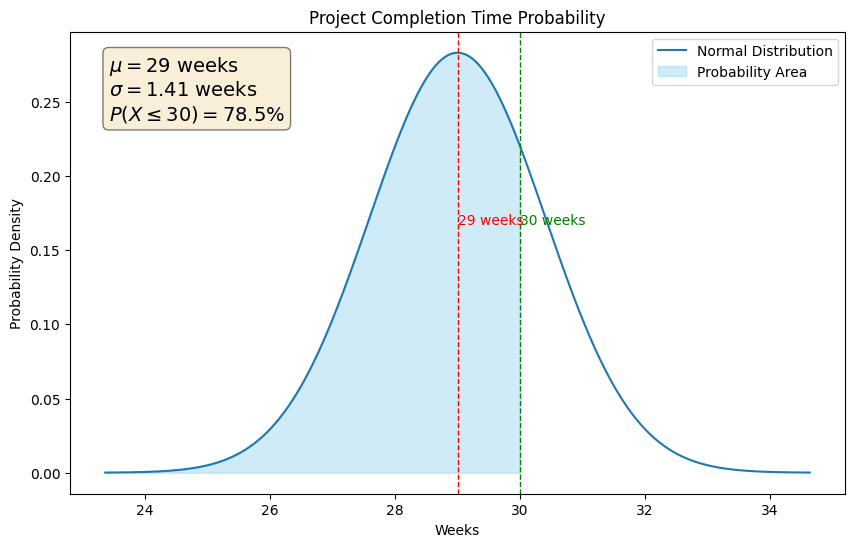

In [45]:
plan = computeCPM(plan)

printPlan(plan)

due_date = 30
mean = 29
standard_deviation = 1.41

z_score = (due_date - mean) / standard_deviation

probability = stats.norm.cdf(z_score)

print(f'z-score: {z_score:.3f}')
print(f'Probability of completing the project within '
      f'{due_date} weeks: {probability:.2%}')


mu = 29
sigma = 1.41
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, label = 'Normal Distribution')
ax.fill_between(x, y, where=(x <= 30), color = 'skyblue', alpha = 0.4, label = 'Probability Area')

plt.title('Project Completion Time Probability')
plt.xlabel('Weeks')
plt.ylabel('Probability Density')
plt.axvline(mu, color = 'r', linestyle = 'dashed', linewidth = 1)
plt.text(mu, max(y)*0.6, '29 weeks', rotation = 0, verticalalignment = 'center', color = 'r')
plt.axvline(30, color = 'g', linestyle = 'dashed', linewidth = 1)
plt.text(30, max(y)*0.6, '30 weeks', rotation = 0, verticalalignment = 'center', color = 'g')

props = dict(boxstyle = 'round', facecolor = 'wheat', alpha = 0.5)
textstr = '\n'.join((
    r'$\mu=29$ weeks',
    r'$\sigma=1.41$ weeks',
    r'$P(X \leq 30) = 78.5\%$'))
plt.text(0.05, 0.95, textstr, transform = ax.transAxes, fontsize = 14,
        verticalalignment = 'top', bbox = props)

plt.legend()
plt.show()